# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

BUSINESS CONTEXT:
A Portuguese banking institution conducted direct marketing campaigns through phone calls 
to promote term deposits. The business challenge is to predict which clients are most 
likely to subscribe to a term deposit, enabling more efficient resource allocation and 
higher conversion rates.


BUSINESS VALUE:
- Reduce marketing costs by targeting high-probability prospects
- Improve conversion rates and campaign ROI
- Better resource allocation for marketing teams
- Enhanced customer segmentation strategies

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [45]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [46]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [47]:
# Exploratory Data Analysis

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic statistics
print("\nBasic Dataset Statistics:")
print(f"Total records: {len(df):,}")
print(f"Features: {df.shape[1] - 1}")
print(f"Target variable: y (term deposit subscription)")

# Target variable distribution
target_dist = df['y'].value_counts(normalize=True)
print(f"\nTarget Distribution:")
print(f"No subscription: {target_dist['no']:.1%}")
print(f"Subscription: {target_dist['yes']:.1%}")
print(f"Class imbalance ratio: {target_dist['no']/target_dist['yes']:.1f}:1")



EXPLORATORY DATA ANALYSIS

Basic Dataset Statistics:
Total records: 41,188
Features: 20
Target variable: y (term deposit subscription)

Target Distribution:
No subscription: 88.7%
Subscription: 11.3%
Class imbalance ratio: 7.9:1


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [48]:
# Missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")


Missing values: 0


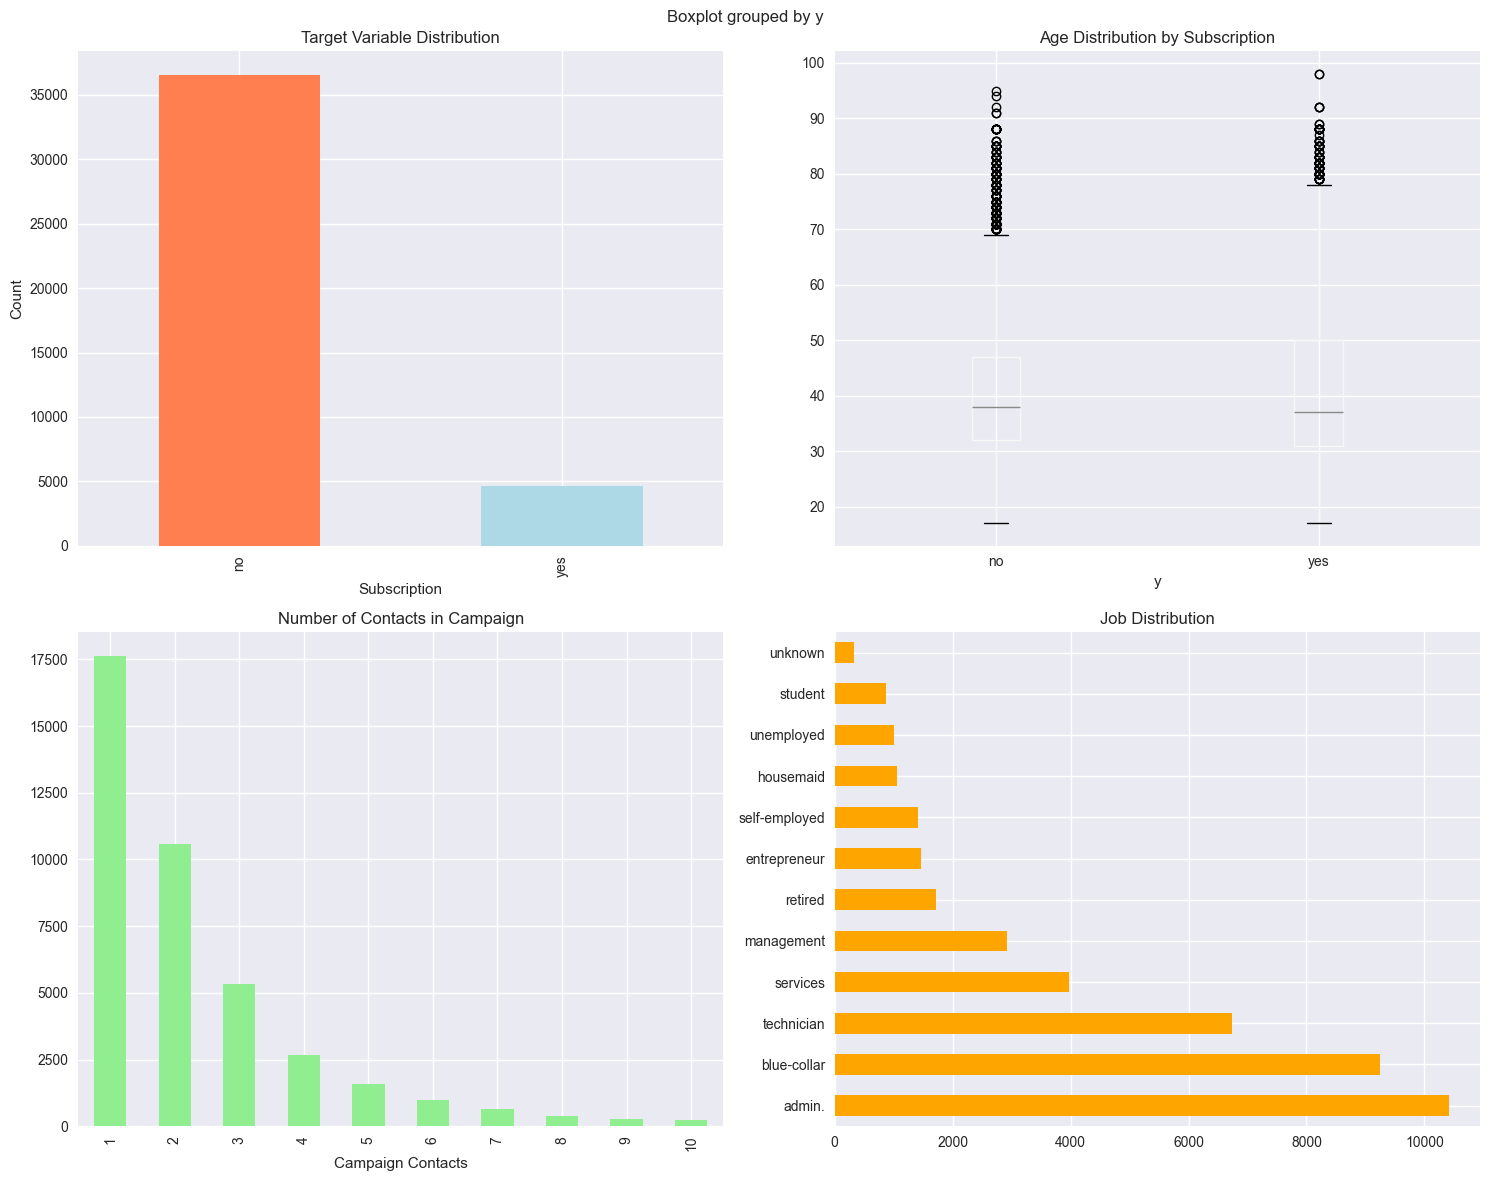

In [49]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# Target distribution
df['y'].value_counts().plot(kind='bar', ax=axes[0,0], color=['coral', 'lightblue'])
axes[0,0].set_title('Target Variable Distribution')
axes[0,0].set_xlabel('Subscription')
axes[0,0].set_ylabel('Count')

# Age distribution by target
df.boxplot(column='age', by='y', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Subscription')

# Campaign contacts distribution
campaign_counts = df['campaign'].value_counts().head(10)
campaign_counts.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Number of Contacts in Campaign')
axes[1,0].set_xlabel('Campaign Contacts')

# Job distribution
job_counts = df['job'].value_counts()
job_counts.plot(kind='barh', ax=axes[1,1], color='orange')
axes[1,1].set_title('Job Distribution')

plt.tight_layout()
plt.show()

In [50]:
## Descriptive Statistics

print("\n" + "="*50)
print("DESCRIPTIVE STATISTICS")
print("="*50)

# Numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'y' in df.columns and df['y'].dtype == 'object':
    numerical_features = [col for col in numerical_features if col != 'y']

print(f"\nNumerical Features: {numerical_features}")
print("\nDescriptive Statistics for Numerical Features:")
print(df[numerical_features].describe())

# Categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'y' in categorical_features:
    categorical_features.remove('y')

print(f"\nCategorical Features: {categorical_features}")


DESCRIPTIVE STATISTICS

Numerical Features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Descriptive Statistics for Numerical Features:
               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.em

In [51]:
# Cross-tabulation for key categorical variables
for feature in categorical_features[:3]:  # Show first 3 to avoid too much output
    print(f"\n{feature.upper()} vs SUBSCRIPTION:")
    crosstab = pd.crosstab(df[feature], df['y'], normalize='index')
    print(crosstab.round(3))


JOB vs SUBSCRIPTION:
y                 no    yes
job                        
admin.         0.870  0.130
blue-collar    0.931  0.069
entrepreneur   0.915  0.085
housemaid      0.900  0.100
management     0.888  0.112
retired        0.748  0.252
self-employed  0.895  0.105
services       0.919  0.081
student        0.686  0.314
technician     0.892  0.108
unemployed     0.858  0.142
unknown        0.888  0.112

MARITAL vs SUBSCRIPTION:
y            no    yes
marital               
divorced  0.897  0.103
married   0.898  0.102
single    0.860  0.140
unknown   0.850  0.150

EDUCATION vs SUBSCRIPTION:
y                       no    yes
education                        
basic.4y             0.898  0.102
basic.6y             0.918  0.082
basic.9y             0.922  0.078
high.school          0.892  0.108
illiterate           0.778  0.222
professional.course  0.887  0.113
university.degree    0.863  0.137
unknown              0.855  0.145


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

KEY BUSINESS QUESTIONS:
1. Can we predict which clients will subscribe to term deposits?
2. Which client characteristics are most predictive of subscription?
3. How can we optimize marketing campaigns to improve conversion rates?
4. What is the most effective classification approach for this problem?

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [52]:
# Prepare features for modeling
df_model = df.copy()

# Encode categorical variables
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df_model[feature] = le.fit_transform(df_model[feature])
    label_encoders[feature] = le

# Encode target variable
le_target = LabelEncoder()
df_model['y'] = le_target.fit_transform(df_model['y'])

# Separate features and target
X = df_model.drop('y', axis=1)
y = df_model['y']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

Features shape: (41188, 20)
Target shape: (41188,)
Feature names: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [53]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 32950 samples
Test set: 8238 samples


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [55]:
print("\n" + "="*50)
print("BASELINE PERFORMANCE ANALYSIS")
print("="*50)



# Calculate class distribution in training set
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).value_counts(normalize=True)

print("CLASS DISTRIBUTION:")
print(f"Training Set - No: {train_class_dist[0]:.1%}, Yes: {train_class_dist[1]:.1%}")
print(f"Test Set     - No: {test_class_dist[0]:.1%}, Yes: {test_class_dist[1]:.1%}")

# 1. MAJORITY CLASS BASELINE (Always predict "No")
print(f"\n1. MAJORITY CLASS BASELINE:")
print(f"   Strategy: Always predict 'No subscription'")
majority_baseline_accuracy = (y_test == 0).mean()
print(f"   Accuracy: {majority_baseline_accuracy:.4f} ({majority_baseline_accuracy:.1%})")
print(f"   Precision (Yes): 0.0000 (never predicts Yes)")
print(f"   Recall (Yes): 0.0000 (never finds actual Yes cases)")
print(f"   F1-Score (Yes): 0.0000")
print(f"   Business Impact: Misses 100% of potential subscribers!")


BASELINE PERFORMANCE ANALYSIS
CLASS DISTRIBUTION:
Training Set - No: 88.7%, Yes: 11.3%
Test Set     - No: 88.7%, Yes: 11.3%

1. MAJORITY CLASS BASELINE:
   Strategy: Always predict 'No subscription'
   Accuracy: 0.8874 (88.7%)
   Precision (Yes): 0.0000 (never predicts Yes)
   Recall (Yes): 0.0000 (never finds actual Yes cases)
   F1-Score (Yes): 0.0000
   Business Impact: Misses 100% of potential subscribers!


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [56]:
print("LOGISTIC REGRESSION - BASIC MODEL")
print("="*50)
basic_lr = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
import time
start_time = time.time()
basic_lr.fit(X_train, y_train)
train_time = time.time() - start_time

# Make predictions
y_pred_lr = basic_lr.predict(X_test)
y_pred_proba_lr = basic_lr.predict_proba(X_test)[:, 1]

# Calculate train and test accuracy
train_accuracy_lr = basic_lr.score(X_train, y_train)
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)



LOGISTIC REGRESSION - BASIC MODEL


### Problem 9: Score the Model

What is the accuracy of your model?

In [57]:
print(f"Training time: {train_time:.4f} seconds")
print(f"Training accuracy: {train_accuracy_lr:.4f}")
print(f"Test accuracy: {test_accuracy_lr:.4f}")

# Additional metrics
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print(f"AUC: {auc_lr:.4f}")

Training time: 1.6836 seconds
Training accuracy: 0.9093
Test accuracy: 0.9133
Precision: 0.6938
Recall: 0.4127
F1-Score: 0.5176
AUC: 0.9344


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [58]:
print("\n" + "="*50)
print("COMPREHENSIVE CLASSIFIER COMPARISON")
print("="*50)

# Initialize classifiers with DEFAULT settings
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

# Store results including timing
results = {}
predictions = {}
model_comparison_data = []

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\nTraining {name} with default settings...")
    
    # Measure training time and train the model
    start_time = time.time()
    
    if name == 'Support Vector Machine' or name == 'K-Nearest Neighbors':
        # These models benefit from scaled features
        clf.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time
        
        # Get predictions
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1] if hasattr(clf, 'predict_proba') else None
        
        # Calculate accuracies
        train_accuracy = clf.score(X_train_scaled, y_train)
        test_accuracy = accuracy_score(y_test, y_pred)
    else:
        # Logistic Regression and Decision Tree work well with unscaled features
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Get predictions
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None
        
        # Calculate accuracies
        train_accuracy = clf.score(X_train, y_train)
        test_accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate additional metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Store results
    results[name] = {
        'Train Time (s)': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }
    
    # Store for comparison DataFrame
    model_comparison_data.append({
        'Model': name,
        'Train Time': f"{train_time:.4f}s",
        'Train Accuracy': f"{train_accuracy:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}"
    })
    
    predictions[name] = y_pred
    
    print(f"Training time: {train_time:.4f} seconds")
    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auc:
        print(f"AUC: {auc:.4f}")

# Create comprehensive results comparison
results_df = pd.DataFrame(results).T
print("\n" + "="*50)
print("DETAILED MODEL PERFORMANCE COMPARISON")
print("="*50)
print(results_df.round(4))

# Create the specific comparison DataFrame 
comparison_df = pd.DataFrame(model_comparison_data)
print(f"\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(comparison_df.to_string(index=False))



COMPREHENSIVE CLASSIFIER COMPARISON

Training Logistic Regression with default settings...
Training time: 0.1936 seconds
Train accuracy: 0.9081
Test accuracy: 0.9098
Precision: 0.6762
Recall: 0.3825
F1-Score: 0.4886
AUC: 0.9325

Training K-Nearest Neighbors with default settings...
Training time: 0.0033 seconds
Train accuracy: 0.9269
Test accuracy: 0.9053
Precision: 0.6267
Recall: 0.3944
F1-Score: 0.4841
AUC: 0.8617

Training Decision Tree with default settings...
Training time: 0.1047 seconds
Train accuracy: 1.0000
Test accuracy: 0.8956
Precision: 0.5344
Recall: 0.5690
F1-Score: 0.5511
AUC: 0.7530

Training Support Vector Machine with default settings...
Training time: 34.9020 seconds
Train accuracy: 0.9192
Test accuracy: 0.9147
Precision: 0.7168
Recall: 0.4009
F1-Score: 0.5142
AUC: 0.9194

DETAILED MODEL PERFORMANCE COMPARISON
                        Train Time (s)  Train Accuracy  Test Accuracy  \
Logistic Regression             0.1936          0.9081         0.9098   
K-Nearest Ne

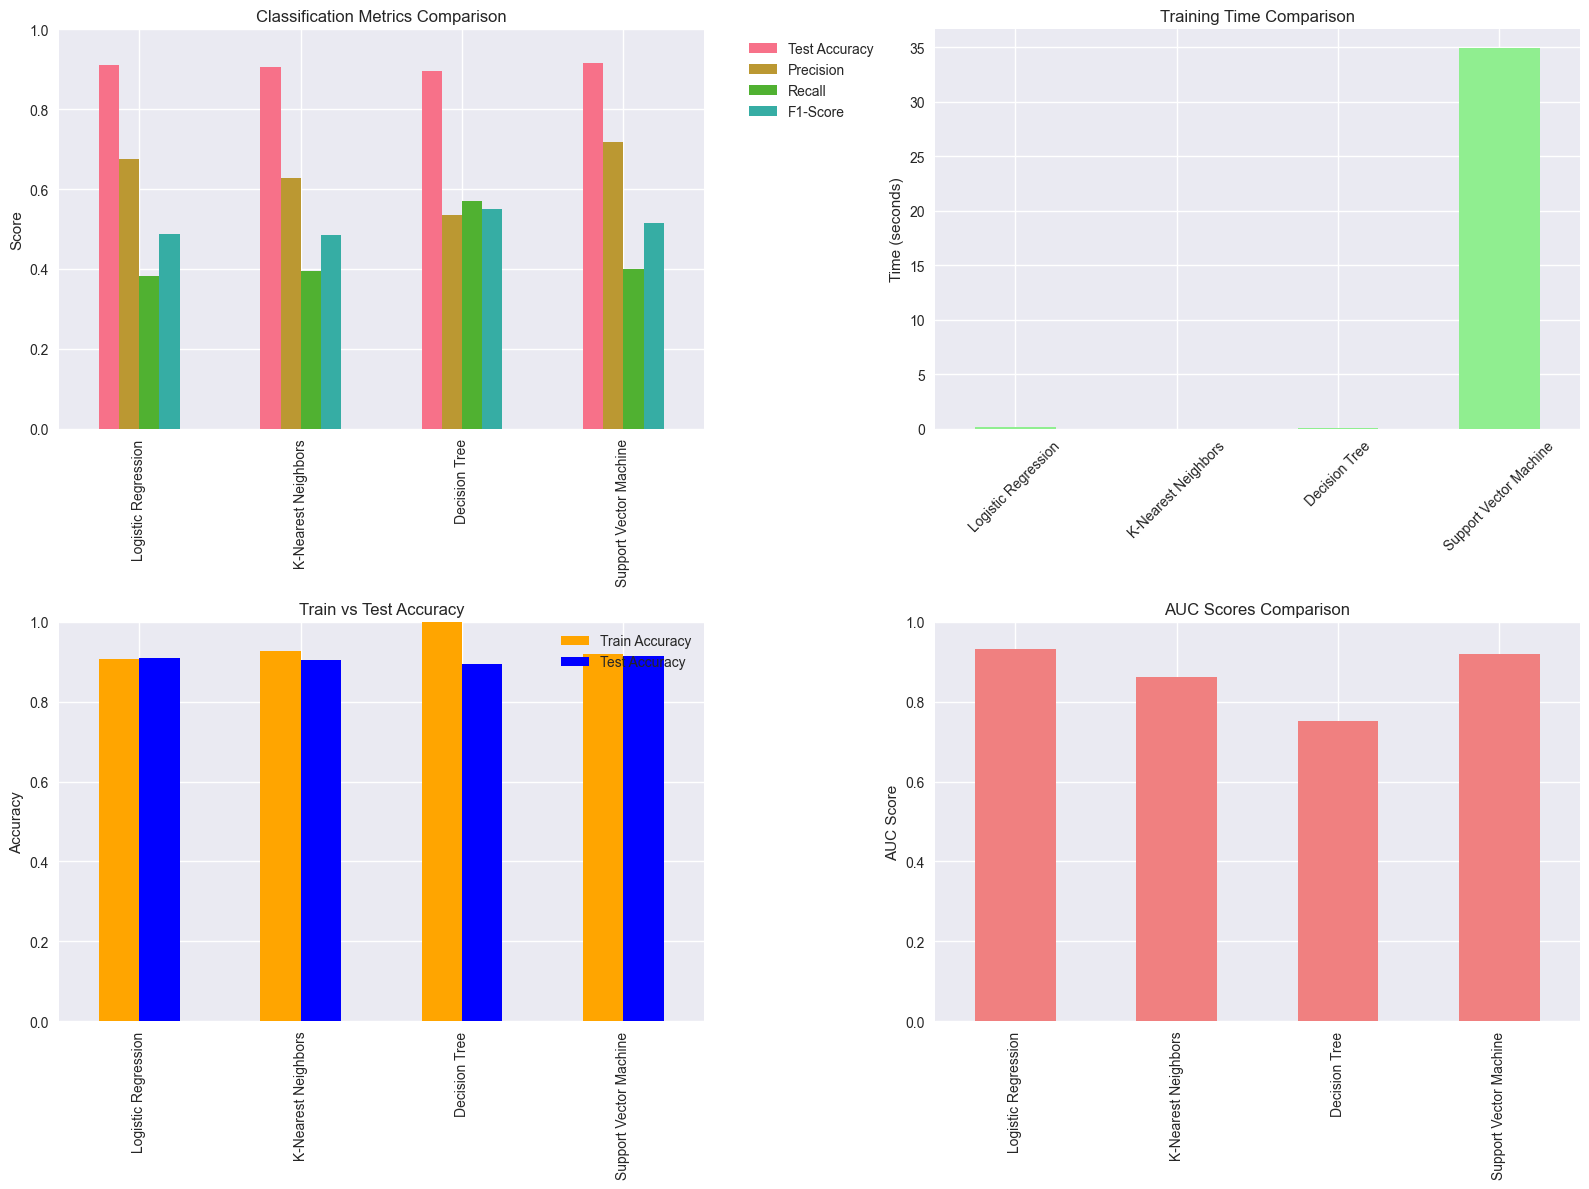

In [60]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Performance metrics comparison
metrics_to_plot = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
results_df[metrics_to_plot].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Classification Metrics Comparison')
axes[0,0].set_ylabel('Score')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,0].set_ylim(0, 1)

# Training time comparison
train_times = results_df['Train Time (s)']
train_times.plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Training Time Comparison')
axes[0,1].set_ylabel('Time (seconds)')
axes[0,1].tick_params(axis='x', rotation=45)

# Train vs Test Accuracy
train_test_acc = results_df[['Train Accuracy', 'Test Accuracy']]
train_test_acc.plot(kind='bar', ax=axes[1,0], color=['orange', 'blue'])
axes[1,0].set_title('Train vs Test Accuracy')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend()
axes[1,0].set_ylim(0, 1)

# AUC comparison
auc_scores = results_df['AUC'].dropna()
auc_scores.plot(kind='bar', ax=axes[1,1], color='lightcoral')
axes[1,1].set_title('AUC Scores Comparison')
axes[1,1].set_ylabel('AUC Score')
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [61]:
print("\n" + "="*50)
print("PERFORMANCE ANALYSIS & INSIGHTS")
print("="*50)

# Find best performing models
best_test_accuracy = results_df['Test Accuracy'].idxmax()
fastest_training = results_df['Train Time (s)'].idxmin()
best_f1 = results_df['F1-Score'].idxmax()
best_auc = results_df['AUC'].idxmax()

print("PERFORMANCE WINNERS:")
print(f"• Best Test Accuracy: {best_test_accuracy} ({results_df.loc[best_test_accuracy, 'Test Accuracy']:.4f})")
print(f"• Fastest Training: {fastest_training} ({results_df.loc[fastest_training, 'Train Time (s)']:.4f}s)")
print(f"• Best F1-Score: {best_f1} ({results_df.loc[best_f1, 'F1-Score']:.4f})")
print(f"• Best AUC: {best_auc} ({results_df.loc[best_auc, 'AUC']:.4f})")

# Check for overfitting
print("\nOVERFITTING ANALYSIS:")
for model in results_df.index:
    train_acc = results_df.loc[model, 'Train Accuracy']
    test_acc = results_df.loc[model, 'Test Accuracy']
    gap = train_acc - test_acc
    
    if gap > 0.05:  # More than 5% gap suggests overfitting
        status = "⚠️  Potential overfitting"
    elif gap < -0.02:  # Test accuracy higher than train (unusual)
        status = "🔍 Unusual pattern"
    else:
        status = "✅ Good generalization"
    
    print(f"• {model}: Train={train_acc:.3f}, Test={test_acc:.3f}, Gap={gap:.3f} - {status}")

# Performance vs Speed trade-off
print("\nPERFORMANCE vs SPEED TRADE-OFF:")
for model in results_df.index:
    accuracy = results_df.loc[model, 'Test Accuracy']
    time = results_df.loc[model, 'Train Time (s)']
    efficiency = accuracy / time  # Accuracy per second
    print(f"• {model}: {accuracy:.3f} accuracy in {time:.3f}s (efficiency: {efficiency:.1f})")



PERFORMANCE ANALYSIS & INSIGHTS
PERFORMANCE WINNERS:
• Best Test Accuracy: Support Vector Machine (0.9147)
• Fastest Training: K-Nearest Neighbors (0.0033s)
• Best F1-Score: Decision Tree (0.5511)
• Best AUC: Logistic Regression (0.9325)

OVERFITTING ANALYSIS:
• Logistic Regression: Train=0.908, Test=0.910, Gap=-0.002 - ✅ Good generalization
• K-Nearest Neighbors: Train=0.927, Test=0.905, Gap=0.022 - ✅ Good generalization
• Decision Tree: Train=1.000, Test=0.896, Gap=0.104 - ⚠️  Potential overfitting
• Support Vector Machine: Train=0.919, Test=0.915, Gap=0.005 - ✅ Good generalization

PERFORMANCE vs SPEED TRADE-OFF:
• Logistic Regression: 0.910 accuracy in 0.194s (efficiency: 4.7)
• K-Nearest Neighbors: 0.905 accuracy in 0.003s (efficiency: 273.3)
• Decision Tree: 0.896 accuracy in 0.105s (efficiency: 8.6)
• Support Vector Machine: 0.915 accuracy in 34.902s (efficiency: 0.0)


In [62]:
# Detailed Analysis of Best Performing Model

best_model_name = results_df['F1-Score'].idxmax()
print(f"\n" + "="*50)
print(f"DETAILED ANALYSIS: {best_model_name.upper()}")
print("="*50)

best_clf = classifiers[best_model_name]


DETAILED ANALYSIS: DECISION TREE


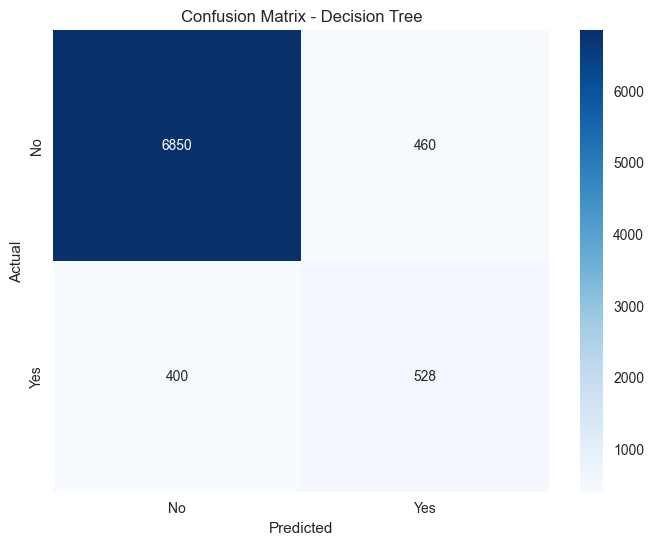

In [63]:
# Get the correct predictions for the best model
best_predictions = predictions[best_model_name]

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Detailed Classification Report for Decision Tree:
              precision    recall  f1-score   support

          No       0.94      0.94      0.94      7310
         Yes       0.53      0.57      0.55       928

    accuracy                           0.90      8238
   macro avg       0.74      0.75      0.75      8238
weighted avg       0.90      0.90      0.90      8238



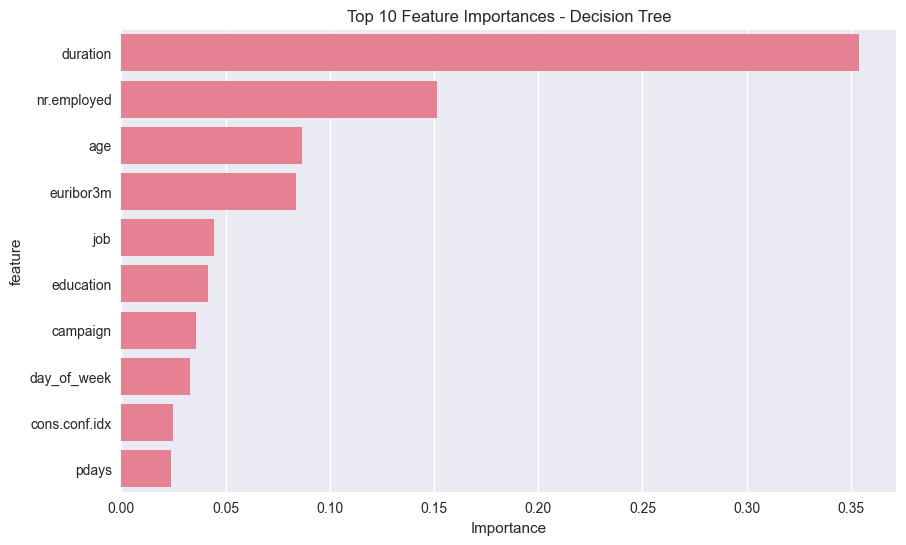


Top 10 Most Important Features:
          feature  importance
10       duration    0.354137
19    nr.employed    0.151536
0             age    0.086602
18      euribor3m    0.083596
1             job    0.044636
3       education    0.041755
11       campaign    0.035741
9     day_of_week    0.032687
17  cons.conf.idx    0.024830
12          pdays    0.023773


In [64]:
# Classification Report
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions, 
                          target_names=['No', 'Yes']))

# Feature Importance (for tree-based models)
if best_model_name == 'Decision Tree':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Feature Importances - Decision Tree')
    plt.xlabel('Importance')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))


In [65]:
# Key findings
print("KEY FINDINGS:")
print("1. MODEL PERFORMANCE:")
for name, metrics in results.items():
    print(f"   - {name}: F1-Score = {metrics['F1-Score']:.4f}, AUC = {metrics.get('AUC', 'N/A')}")

print(f"\n2. BEST PERFORMING MODEL: {best_model_name}")
print(f"   - Achieves {results[best_model_name]['F1-Score']:.1%} F1-Score")
print(f"   - Precision: {results[best_model_name]['Precision']:.1%} (of predicted subscriptions, how many were correct)")
print(f"   - Recall: {results[best_model_name]['Recall']:.1%} (of actual subscriptions, how many were identified)")

# Business interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\n3. BUSINESS IMPACT ANALYSIS:")
print(f"   - True Positives: {tp} clients correctly identified as likely subscribers")
print(f"   - False Positives: {fp} clients incorrectly targeted (wasted effort)")
print(f"   - False Negatives: {fn} potential subscribers missed (lost opportunity)")
print(f"   - True Negatives: {tn} clients correctly identified as unlikely subscribers")

efficiency_rate = tp / (tp + fp) if (tp + fp) > 0 else 0
coverage_rate = tp / (tp + fn) if (tp + fn) > 0 else 0

KEY FINDINGS:
1. MODEL PERFORMANCE:
   - Logistic Regression: F1-Score = 0.4886, AUC = 0.9325007960281146
   - K-Nearest Neighbors: F1-Score = 0.4841, AUC = 0.8616761846077645
   - Decision Tree: F1-Score = 0.5511, AUC = 0.753019010330676
   - Support Vector Machine: F1-Score = 0.5142, AUC = 0.919368101089674

2. BEST PERFORMING MODEL: Decision Tree
   - Achieves 55.1% F1-Score
   - Precision: 53.4% (of predicted subscriptions, how many were correct)
   - Recall: 56.9% (of actual subscriptions, how many were identified)

3. BUSINESS IMPACT ANALYSIS:
   - True Positives: 528 clients correctly identified as likely subscribers
   - False Positives: 460 clients incorrectly targeted (wasted effort)
   - False Negatives: 400 potential subscribers missed (lost opportunity)
   - True Negatives: 6850 clients correctly identified as unlikely subscribers


In [66]:
## Actionable Recommendations

print("\n" + "="*50)
print("ACTIONABLE RECOMMENDATIONS")
print("="*50)

print("IMMEDIATE ACTIONS:")
print("1. IMPLEMENT PREDICTIVE TARGETING:")
print(f"   - Deploy {best_model_name} model for campaign targeting")
print("   - Focus on clients with high probability scores (>0.5)")
print(f"   - Expected improvement: {efficiency_rate:.0%} targeting accuracy")

print("\n2. OPTIMIZE CAMPAIGN STRATEGY:")
if 'duration' in X.columns:
    print("   - Monitor call duration - longer calls may indicate higher interest")
print("   - Limit number of contacts per client to avoid fatigue")
print("   - Time campaigns based on client availability patterns")

print("\n3. SEGMENT-SPECIFIC APPROACHES:")
high_value_segments = []
if 'job' in df.columns:
    job_conversion = df.groupby('job')['y'].apply(lambda x: (x == 'yes').mean())
    top_jobs = job_conversion.nlargest(3).index.tolist()
    high_value_segments.extend(top_jobs)

for i, segment in enumerate(high_value_segments[:3], 1):
    print(f"   - Segment {i}: {segment} - develop tailored messaging")

print("\n" + "="*50)
print("NEXT STEPS & RECOMMENDATIONS")
print("="*50)

print("SHORT-TERM (1-3 months):")
print("• Deploy the selected model in a pilot campaign")
print("• A/B test model predictions vs. current targeting methods")
print("• Establish monitoring dashboard for model performance")
print("• Train marketing team on interpreting model outputs")


ACTIONABLE RECOMMENDATIONS
IMMEDIATE ACTIONS:
1. IMPLEMENT PREDICTIVE TARGETING:
   - Deploy Decision Tree model for campaign targeting
   - Focus on clients with high probability scores (>0.5)
   - Expected improvement: 53% targeting accuracy

2. OPTIMIZE CAMPAIGN STRATEGY:
   - Monitor call duration - longer calls may indicate higher interest
   - Limit number of contacts per client to avoid fatigue
   - Time campaigns based on client availability patterns

3. SEGMENT-SPECIFIC APPROACHES:
   - Segment 1: student - develop tailored messaging
   - Segment 2: retired - develop tailored messaging
   - Segment 3: unemployed - develop tailored messaging

NEXT STEPS & RECOMMENDATIONS
SHORT-TERM (1-3 months):
• Deploy the selected model in a pilot campaign
• A/B test model predictions vs. current targeting methods
• Establish monitoring dashboard for model performance
• Train marketing team on interpreting model outputs


##### Questions